### This notebook is to perform random forest classification on Ratio_Activation

In [1]:
import numpy as np
import pandas as pd
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from nested_cv import NestedCV
from sklearn.metrics import roc_auc_score

In [2]:
taxa = pd.read_csv('../data/57316_deblur_taxonomy/taxonomy.tsv', sep='\t', index_col='Feature ID')

In [3]:
taxa.head()

,Taxon,Confidence
Feature ID,,
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGACGCTCAACGTCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGG,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,1.000000
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGATGCTCAACATCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGG,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,1.000000
TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGGCGGCGGCGTAAGTCAGTTGTGAAATCGTGCGGCTTAACCGTGCAATTGCAGTTGATACTGCGTCGCTTGAGTGCACACAGGGATGTTGGAATTCATGG,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,1.000000
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGAGGCTCAACCTCTGCACTGCAGCGCGAACTGGTCTTCTTGAGTACGCACAACGTGGGCGGAATTCGTGG,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.999998
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTTTGTTAAGCGTGTTGTGAAATGTCGGGGCTCAACCTGGGCATTGCAGCGCGAACTGGCAGACTTGAGTGCGCGGGAAGTAGGCGGAATTCGTCG,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.999991


In [4]:
mf = pd.read_csv('../data/mros_mapping_alpha.txt', sep='\t', index_col='#SampleID')

In [5]:
mf.head()

,BarcodeSequence,LinkerPrimerSequence,Experiment_Design_Description,Library_Construction_Protocol,Linker,Platform,Center_Name,Center_Project,Instrument_Model,Title,...,ratio_catabolism,QLCOMP,M1STATIN,Antihistamine,Laxative,MIDATA,Rstarch_total,Rstarches_c,M1PPUMP,alpha_pd
#SampleID,,,,,,,,,,,,,,,,,,,,,
BI0023,TCTGGTGACATT,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.068605,1:GOOD/EXCELLENT,0: No,0:No,0:No,1: Yes,3.066569,0.0,0: No,30.021398
BI0056,CAAGCATGCCTA,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.099745,1:GOOD/EXCELLENT,0: No,0:No,0:No,1: Yes,3.038136,0.0,1: Yes,18.414977
BI0131,CTATTTGCGACA,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.064502,1:GOOD/EXCELLENT,1: Yes,0:No,0:No,1: Yes,2.840599,0.0,0: No,25.756952
BI0153,ATCGGCGTTACA,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.078388,1:GOOD/EXCELLENT,1: Yes,0:No,0:No,1: Yes,4.106798,0.0,0: No,20.167914
BI0215,CCTCTCGTGATC,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.109697,1:GOOD/EXCELLENT,0: No,0:No,0:No,1: Yes,0.971114,0.0,0: No,20.714331


In [6]:
# create extreme categories on Vitamin D measurements
mf = mf[['OHV1D3', 'OHV24D3', 'OHVD3', 'ratio_activation', 'ratio_catabolism', 'VDstatus']]
mf.shape

(598, 6)

In [7]:
mf.describe()

,OHV1D3,OHV24D3,OHVD3,ratio_activation,ratio_catabolism
count,566.000000,566.000000,555.000000,555.000000,555.000000
mean,0.057802,3.431343,35.224865,0.001774,0.094795
std,0.019780,1.836358,12.461583,0.000735,0.029794
min,0.010700,0.300000,7.800000,0.000398,0.018788
25%,0.044125,2.167500,27.400000,0.001319,0.074162
50%,0.055500,3.185000,33.600000,0.001661,0.092838
75%,0.066350,4.237500,41.850000,0.002081,0.113049
max,0.156000,14.070000,104.000000,0.006727,0.197786


/Users/ssun/miniconda3/envs/python3-new/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


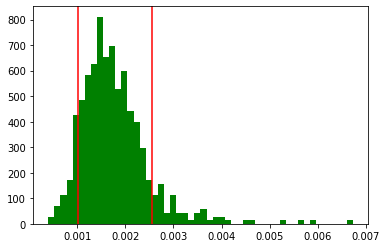

In [8]:
n, bins, patches = plt.hist(mf.ratio_activation.dropna(), 50, normed=1, facecolor='green')
plt.axvline(x=mf['ratio_activation'].quantile([0.10]).values, color='r')
plt.axvline(x=mf['ratio_activation'].quantile([0.90]).values, color='r')

In [9]:
q1 = mf['ratio_activation'].quantile([0.10]).values
q3 = mf['ratio_activation'].quantile([0.90]).values
def act_extreme(x):
    if (x <= q1):
        return(0)
    elif (x >= q3):
        return(1)
    else:
        return('NaN')
mf['Ract_cat'] = mf['ratio_activation'].apply(act_extreme)

In [10]:
mf['Ract_cat'].value_counts()

NaN    486
1       56
0       56
Name: Ract_cat, dtype: int64

In [11]:
table = pd.read_csv('../data/57316_mros_otus_rare_exp/57316_feature-table-rare.txt', sep='\t', skiprows = 1, index_col = "#OTU ID").transpose()

In [12]:
table.shape

(598, 25292)

In [13]:
## match metadata and OTU table by sampleID
sample_ids = mf.index
sample_ids

Index(['BI0023', 'BI0056', 'BI0131', 'BI0153', 'BI0215', 'BI0353', 'BI0371',
       'BI0372', 'BI0380', 'BI0389',
       ...
       'SD8954', 'SD8964', 'SD8966', 'SD8972', 'SD8973', 'SD8985', 'SD8996',
       'SD8999', 'SD9003', 'SD9009'],
      dtype='object', name='#SampleID', length=598)

In [14]:
table = table.loc[sample_ids] # order rows in same order as matrix's rows (sampleIDs)

In [15]:
table.head()

#OTU ID,TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGACGCTCAACGTCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGG,TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGATGCTCAACATCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGG,TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGGCGGCGGCGTAAGTCAGTTGTGAAATCGTGCGGCTTAACCGTGCAATTGCAGTTGATACTGCGTCGCTTGAGTGCACACAGGGATGTTGGAATTCATGG,TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGAGGCTCAACCTCTGCACTGCAGCGCGAACTGGTCTTCTTGAGTACGCACAACGTGGGCGGAATTCGTGG,TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTTTGTTAAGCGTGTTGTGAAATGTCGGGGCTCAACCTGGGCATTGCAGCGCGAACTGGCAGACTTGAGTGCGCGGGAAGTAGGCGGAATTCGTCG,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGG,TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGCAGGTTAAGCGTGTTGTGAAATGTAGGGGCTCAACCTCTGCACTGCAGCGCGAACTGGCTTGCTTGAGTACGCACAACGTGGGCGGAATTCGTGG,TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTCTTATAAGCGTGTTGTGAAATGTCGGGGCTCAACCTGGGCATTGCAGCGCGAACTGTGAGACTTGAGTGCGCAGGAAGTAGGCGGAATTCGTCG,TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGATGCTCAACATCTGAACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGG,...,TACGTATGGAGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGCCGGGAGGGCAAGTCAGATGTGAAATCCACGGGCTCAACTCGTGAACTGCATTGGAAACTGTCGTACTAGAGTGTCGGAGGGGTAAGCGGAATTCCTAG,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGATAGGCAAGTCTGGAGTGAAAACCCAGGGCTCAACCCTGGGACTGCTTTGGAAACTGCAGATCTGGAGTGCTGGAGAGGTAAGCGGAATTCCTAG,TACGGAGGGGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGTACGTAGGTGGCCTTTTAAGCGTAGGGTATAAGGCAATGGCCCAACCATTGTTCGCCCTATGAACTGGAAGGCTTGAGTGCAGGAGAGGAAAGCGGAATTCCTAGT,TACGTAGGGGGCAAGCGTTGTCCGGAATGACTGGGCGTAAAGGGAGTGTAGGCGGCTTGGCAAGTTAGATGTGAAAGCCCGCAGCTCAACTGCGGAACTGCATCTAAAACTGTCAGGCTTGAGTGCAGGAGAGGTAAGTGGAACTCCTAG,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGCGGGATGGCAAGTCAGATGTGAAATACCGGGGCTTAACCCCGGGGCTGCATTTGAAACTGTCGTTCTTGAGTGAAGTAGAGGCAGGCGGAATTCCTAG,TACGTAGGGGGCGAGCGTTGTCCGGAATGACTGGGCGTAAAGGGCGTGTAGGCGGCCGATTAAGTGTGGAGTGAAAGTCCACTTGTCAAGGGTGGAATTGCTTTGCAGACTGGTTGGCTTGAGTGCGGAAGAGGTAAGTGGAATTCCCAG,TACGTAGGGGGCAAGCGTTATCCGGAATTACTGGGTGTAAAGGGTGCGTAGGCGGTACGGCAAGTTTGATGTGAAACCCATGGGCTTAACCCATGGCATGCATCGAAAACTACTGAACTAGAGTGCAGGAGAGGAGAGTGGAATTCCTAG,TACGGAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGACTGGCAAGTCTGATGTGAAAGGCGCGGGCTCAACCCGCGGACGGCACATGATACTGCGAGACTAGAGTAATGGAGGGGGAACCGGAATTCTCGG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAAGAGCAAGTCTGATGTGAAAGGCTGGGGCTTAACCCCAGGACTGCATTGGAAACTGTTTTTCTTGAGTGCCGGAGAGGTAAGCGGAATTCTCGG,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAATGGCAAGTCTGATGTGAGAGGCCGGGGCTCAACCCCGGGACTGCATTGGAAACTGTCAATCTAGAGTACCGGAGGGGTAAGTGGAATTCCTAG
#SampleID,,,,,,,,,,,,,,,,,,,,,
BI0023,3.0,0.0,0.0,0.0,0.0,111.0,0.0,0.0,0.0,2181.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BI0056,1.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,3718.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BI0131,0.0,0.0,0.0,0.0,0.0,43.0,0.0,0.0,1.0,222.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BI0153,1.0,1.0,0.0,0.0,0.0,220.0,0.0,0.0,0.0,217.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BI0215,0.0,0.0,0.0,0.0,0.0,176.0,0.0,0.0,0.0,542.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## random forest classification 

### ratio activation

In [16]:
# filter away samples with NaN values
Y = mf[mf.Ract_cat != 'NaN']
Y.shape

(112, 7)

In [17]:
X = table.loc[Y.index]
X.shape

(112, 25292)

In [18]:
# convert to numpy array
# X - rarefied OTU table; Y - vitamin D categories
y = pd.factorize(Y['Ract_cat'])[0] # to get dtype 'int' instead of 'O'
X = X.as_matrix()

/Users/ssun/miniconda3/envs/python3-new/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [19]:
np.random.seed(31)
m = np.logspace(2, 8, num=9, base=2, dtype=int)
p_grid = {"max_features": m,
          "min_samples_split": [2, 3, 7],
          "min_samples_leaf": [1, 3, 7],
          "bootstrap": [True, False]}

rf = RandomForestClassifier(n_estimators=1000)

In [20]:
nested_CV_search = NestedCV(model=rf, params_grid=p_grid , outer_kfolds=5, inner_kfolds=5, n_jobs = 4,
                            cv_options={'metric':roc_auc_score, 
                                        'metric_score_indicator_lower':False, # higher auc score is better
                                        'randomized_search_iter':30, 
                                        'predict_proba':True})
nested_CV_search.fit(X=X,y=y)

In [22]:
np.mean(nested_CV_search.outer_scores)

0.7667748917748918

In [23]:
np.median(nested_CV_search.outer_scores)

0.7583333333333333

In [24]:
nested_CV_search.best_inner_params_list

[{'bootstrap': False,
  'max_features': 256,
  'min_samples_leaf': 7,
  'min_samples_split': 3},
 {'bootstrap': False,
  'max_features': 4,
  'min_samples_leaf': 3,
  'min_samples_split': 7},
 {'bootstrap': True,
  'max_features': 4,
  'min_samples_leaf': 3,
  'min_samples_split': 7},
 {'bootstrap': True,
  'max_features': 4,
  'min_samples_leaf': 7,
  'min_samples_split': 7},
 {'bootstrap': False,
  'max_features': 11,
  'min_samples_leaf': 7,
  'min_samples_split': 3}]